# FlowEmbedder: Snake Test Case

In [1]:
# default_exp datasets
# hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

# Pseudo Code

1) create function that is the "ribbon"
2) sample points from ribbon
3) calculate flow at each point

# Test Example 1: 3D Sinusoidal

In [2]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [3]:
def plot_ribbon(start=-5, end=5.1, increment=0.2, num_points=1000, dim=3):
    '''
    plots sinusoidal ribbon manifold in 3D
    Inputs
    - start: starting point of sinusoidal function
    - end: ending point of sinusoidal function
    - increment: segment size between start and ed
    - num_points: number of points sampled from the sinusoidal manifold
    '''
    fig = plt.figure(figsize = (12,10))
    ax = plt.axes(projection='3d')

    x = np.arange(start, end, increment)
    y = np.arange(start, end, increment)

    X, Y = np.meshgrid(x, y)
    # define function
    Z = np.sin(X)

    surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

    # label axis
    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)
    ax.set_zlabel('z', labelpad=20)

    fig.colorbar(surf, shrink=0.5, aspect=8)

    plt.show()

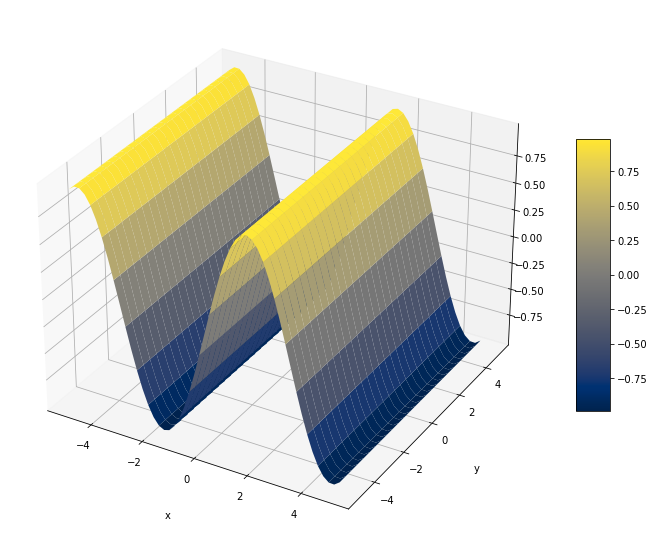

In [4]:
# plot ribbon

plot_ribbon()

In [5]:
def sample_ribbon(start=-5, end=5.1, increment=0.2, num_points=1000, dim=3):
    '''
    sample points uniformly from ribbon
    Inputs
    - start: starting point of sinusoidal function
    - end: ending point of sinusoidal function
    - increment: segment size between start and ed
    - num_points: number of points sampled from the sinusoidal manifold
    Outputs
    - points_mat:
    - flow_mat:
    '''
    # sample points
    sample_x = np.random.uniform(low=start, high=end, size = num_points)
    sample_y = np.random.uniform(low=start, high=end, size = num_points)

    points_mat = np.ndarray(shape=(num_points, dim))
    points_mat[:, 0] = sample_x
    points_mat[:, 1] = sample_y
    points_mat[:, 2] = np.sin(sample_x)

    # calculate flow: unit tangent line at each sampled point
    flow_mat = np.ndarray(shape = (num_points, dim))
    flow_mat[:, 0] = [1] * num_points
    flow_mat[:, 1] = [1] * num_points
    flow_mat[:, 2] = np.cos(sample_x)
    # row normalize
    row_sums = flow_mat.sum(axis=1)
    flow_mat = flow_mat / row_sums[:, np.newaxis]

    return points_mat, flow_mat


In [6]:
X = sample_ribbon()[0] # points
X_ = sample_ribbon()[1] # flows

In [7]:
def plot_ribbon_samples(points_mat, flow_mat):
    '''
    plot points sampled from the manifold with flow at each point, 
    where flow is defined as the unit tangent vector at each point
    Inputs
    - points_mat: matrix where each row is a point
    - flow_mat: matrix where each row is a derivative of each corresponding point in points_mat
    '''
    num_points, d = points_mat.shape
    fig = plt.figure(figsize = (12,10))
    ax = fig.add_subplot(projection='3d')

    # plot points
    plt.scatter(points_mat[:, 0], points_mat[:, 1], points_mat[:, 2])

    # plot flow
    mask_prob = 0 # percentage not plotted
    mask = np.random.rand(num_points) > mask_prob
    ax.quiver(points_mat[mask, 0], points_mat[mask, 1], points_mat[mask, 2], flow_mat[mask, 0], flow_mat[mask, 1], flow_mat[mask, 2], alpha=0.8, length=0.5)

    # label axis
    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)
    ax.set_zlabel('z', labelpad=20)

    plt.show()



/gpfs/ysm/project/sumry2022/sumry2022_gt392/conda_envs/test/lib/python3.9/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


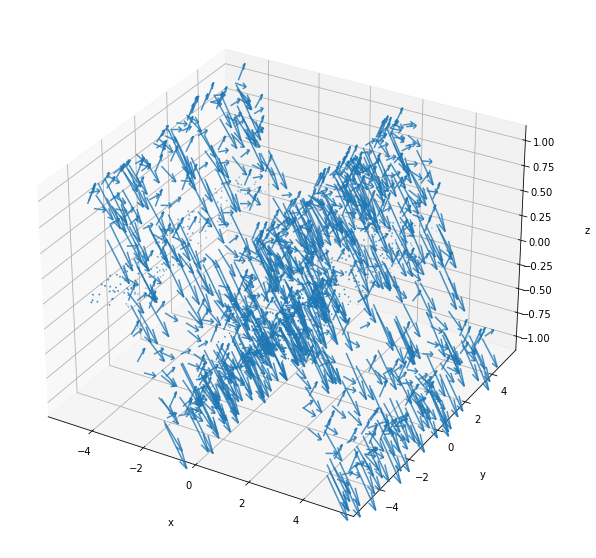

In [8]:
plot_ribbon_samples(X, X_)

References

[1] https://pythonnumericalmethods.berkeley.edu/notebooks/chapter12.02-3D-Plotting.html


## Test on Flow Embedder

In [9]:
import torch
from directed_graphs.datasets import directed_circle, directed_cylinder, directed_spiral, directed_swiss_roll
from directed_graphs.datasets import plot_directed_2d, plot_directed_3d
from directed_graphs.diffusion_flow_embedding import DiffusionFlowEmbedder
import torch
import numpy as np

if torch.__version__[:4] == "1.13":
	device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
else:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
data, flow = sample_ribbon()

In [11]:
X = torch.tensor(data)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [12]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15,device = device)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:32<00:00, 62.26it/s]

Exiting training with loss  tensor(4307.2651, device='cuda:0', grad_fn=<AddBackward0>)


In [13]:
dfe.embedded_points

tensor([[-1.7760,  0.3929],
        [-0.8511,  1.6112],
        [-1.1010,  4.1636],
        ...,
        [-0.0214, -0.1070],
        [-0.6536, -0.4135],
        [-1.3135,  1.0600]], device='cuda:0', grad_fn=<AddmmBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


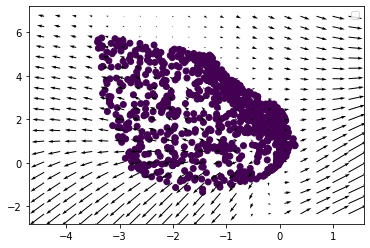

In [14]:
dfe.visualize_points([0 for i in range(len(data))])